# EDA for sequencing run

In [1]:
using CSV, DataFrames, CairoMakie, wgregseq, Statistics

wgregseq.plotting_style.default_makie!()

[ Info: Precompiling wgregseq [57506705-3e72-4664-96ef-b7f153ccca47]


In [2]:
wgregseq.plotting_style.my_color_dict

Dict{String, String} with 15 entries:
  "orange2" => "#fecc96"
  "green3"  => "#e6f0cb"
  "blue2"   => "#8d92c8"
  "blue3"   => "#dbddef"
  "yellow3" => "#fff8c1"
  "purple3" => "#e9d1da"
  "green1"  => "#a8cf38"
  "blue1"   => "#324fa2"
  "yellow1" => "#fce317"
  "green2"  => "#d1e39b"
  "yellow2" => "#fff182"
  "orange1" => "#f47c20"
  "purple1" => "#9f2260"
  "purple2" => "#cca6b6"
  "orange3" => "#ffe4c6"

## Standard Deviation between barcodes of same promoter sequence

["cDNA_count", "gDNA_count", "barcode", "name", "mapping_count", "promoter"]


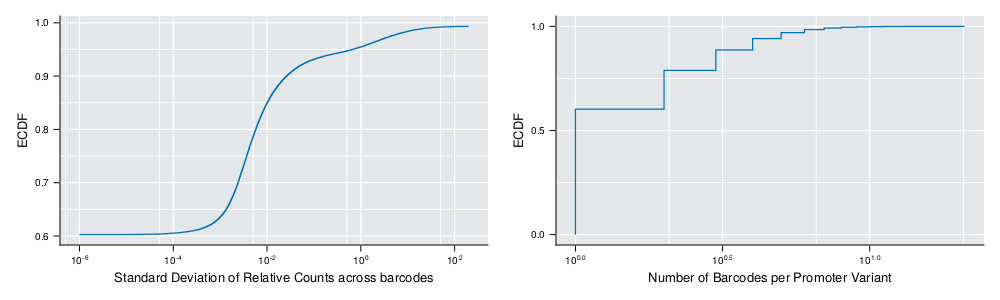

In [3]:
df = CSV.read(
    "../../../data/extracted_barcodes/20221114_barcode/LB_identified.txt", 
    DataFrame, 
    ignorerepeated=true, 
    delim=" ")
println(names(df))

insertcols!(df, 1, :relative_counts => df.cDNA_count ./ df.gDNA_count)

function standard_dev(x)
    if length(x) == 1
        return 0
    else
        return std(x) / sqrt(length(x))
    end
end

cdf_rows = combine(
    groupby(
        df, 
        [:name, :promoter]
        ), 
    nrow)

cdf = combine(
    groupby(
        df, 
        [:name, :promoter]
        ), 
    :relative_counts => standard_dev => :rc_std)[!, [:rc_std, :name, :promoter]]



fig = Figure(resolution=(1000, 300))
ax1 = Axis(fig[1, 1], xscale=log10)
ax1.ylabel = "ECDF"
ax1.xlabel = "Standard Deviation of Relative Counts across barcodes"

ax2 = Axis(fig[1, 2], xscale=log10)
ax2.ylabel = "ECDF"
ax2.xlabel = "Number of Barcodes per Promoter Variant"

ind = findfirst(x -> x>0, sort(cdf.rc_std))

lines!(ax1, sort(cdf.rc_std)[ind:end], ind/nrow(cdf):1/nrow(cdf):1, label="2022")
lines!(ax2, sort(cdf_rows.nrow), 1/nrow(cdf_rows):1/nrow(cdf_rows):1, label="2022")
fig

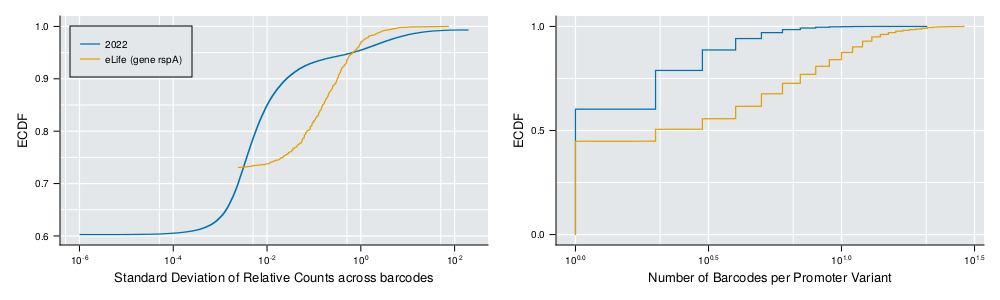

In [4]:
df_reg = CSV.read("data_files/rspA_LB_regseq", DataFrame, ignorerepeated=true, delim=" ")
insertcols!(df_reg, 4, :barcode => map(x -> x[161:180], df_reg.seq))
df_reg.seq = map(x -> x[1:160], df_reg.seq)
insertcols!(df_reg, 1, :relative_counts => df_reg.ct_1 ./ df_reg.ct_0)

cdf_rows_reg = combine(
    groupby(
        df_reg, 
        :seq
        ), 
    nrow)

cdf_reg = combine(
    groupby(
        df_reg, 
        :seq,
        ), 
    :relative_counts => standard_dev => :rc_std)[!, [:rc_std, :seq]]

cdf_reg = cdf_reg[.~ isnan.(cdf_reg.rc_std), :]
ind = findfirst(x -> x > 0, sort(cdf_reg.rc_std))


lines!(ax1, sort(cdf_reg.rc_std)[ind:end], ind/nrow(cdf_reg):1/nrow(cdf_reg):1, label="eLife (gene rspA)")
lines!(ax2, sort(cdf_rows_reg.nrow), 1/nrow(cdf_rows_reg):1/nrow(cdf_rows_reg):1, label="2022")
axislegend(ax1, position=:lt)
fig

## Bardode Bias

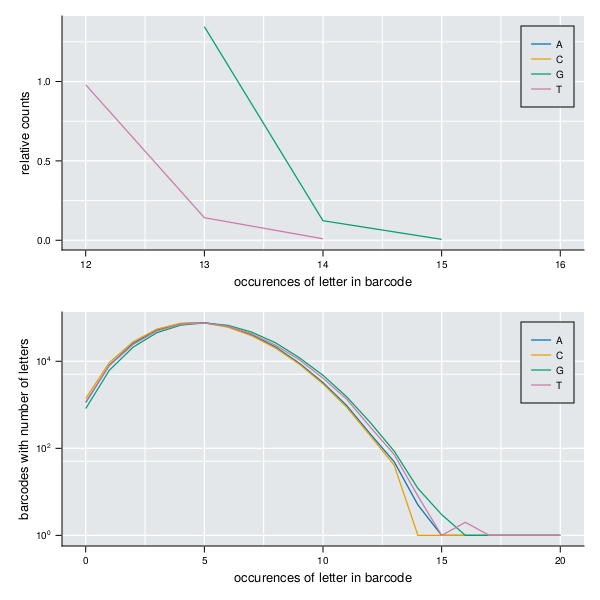

In [5]:
count_letter(seq, x) = sum(map(c -> c == x, collect(seq)))
total_A = map(x -> count_letter(x, 'A'), df.barcode)
total_C = map(x -> count_letter(x, 'C'), df.barcode)
total_G = map(x -> count_letter(x, 'G'), df.barcode)
total_T = map(x -> count_letter(x, 'G'), df.barcode)

fig = Figure(resolution=(600, 600))
ax1 = Axis(fig[1, 1])
ax1.ylabel = "relative counts"
ax1.xlabel = "occurences of letter in barcode"
ax2 = Axis(fig[2, 1], yscale=log10)
ax2.ylabel = "barcodes with number of letters"
ax2.xlabel = "occurences of letter in barcode"

function med(x)
    if length(x) == 0
        return 0
    else
        return median(x)
    end
end

for letter in ['A', 'C', 'G', 'T']
    tot = map(x -> count_letter(x, letter), df.barcode)
    rel_counts_per_letter = [df[tot .== i, :relative_counts] |> mean for i in 0:20]
    lines!(ax1, 0:20, rel_counts_per_letter, label=string(letter))
    lines!(ax2, 0:20, [sum(tot .== i) for i in 0:20] .+ 1, label=string(letter))
end
axislegend(ax1, position=:rt)
axislegend(ax2)
fig

## Barcode counts ranked

Row,cDNA_count,gDNA_count,barcode,name,mapping_count,promoter
,Int64,Int64,String31,String,Int64,String
1,3,167,AAAAAAAACCTCACATTAAT,crpp2,288,GGCGACACAAAGCGAAAGCTATGCTAAAAAAGTCAGGATGCTACAGTAATTCATTGATGTACGGCATGTAAGCACAGGAAGTCACGTTCCCGTGCAGTATAGATGATAGCCCCGTCCCAGCTAGCGGTAAGCATATTTCGGCAATCCAGATACCGCGGCG
2,19,3176,AAAAAAAACGACTAGGAACA,yadI_predicted,54,GGTCCCTGATCCAACGTGGACGGGGTTTGCGTAGCTAAAGCTATTTCCTCTCCTCTGAACTTGGGGGAGGGGAGTTTTGACAGCTATCACCCTTTGTCAACAATGGTCAGGGTAGACTCGTTTTCAGCTAACGCGGACGGCAAGGTTAGGTTGGGTAATT
3,2,65,AAAAAAAATCTGCGTCGTGC,ghoSp,51,GCACAAAGAATGGGCAGAGAGCGCGTTTTTTTGTCCCAAGTCATCCCCGTTACTGTGCAGAAAAATGAAGTTCTCCTATGTGAGAATCATCAATCGGGGATAATGAGTTTTGCGTCCCTAGAGCGTTTTATATTGATAGGCGTCTTAATAGGGAAGCTAA
4,5,651,AAAAAAACAAAGGGTCTCCT,yahC_predicted,3,TAATATCCCCGCCGGCATGAATTAGTGCCAGAACGCAAGCATATTGCTGATATAATCTTGCCAGCGTAATAGCCGTTTTCCCCTAACGAGCGCCGGTATTAGTATCACCACCCAGCGCAAGGCAGCTTTTTATTTTATAGGTATCACCCTGTTGTGCAGC
5,25187,4998,AAAAAAACCCCACCCATGGC,TSS_4655_regulondb,73,GGTCTGTTCAGCTGTGTCTTGAAATAGACGAACGTAAACATAGAACTGGTTCAGTATGGTTCCGTGCTTGCTGGCAGTGTGGGAACTCCAGCATACGACCGAGTCGGAAGTCGTGAAAAGATAGGCACATAACAGCTAAGTCTTTTCAACCAGAGAGAAT


Row,cDNA_count,gDNA_count,barcode,name,mapping_count,promoter
,Int64,Int64,String31,String,Int64,String
1,3,165,AAAAAAAACCTCACATTAAT,crpp2,288,GGCGACACAAAGCGAAAGCTATGCTAAAAAAGTCAGGATGCTACAGTAATTCATTGATGTACGGCATGTAAGCACAGGAAGTCACGTTCCCGTGCAGTATAGATGATAGCCCCGTCCCAGCTAGCGGTAAGCATATTTCGGCAATCCAGATACCGCGGCG
2,27,1769,AAAAAAAACGACTAGGAACA,yadI_predicted,54,GGTCCCTGATCCAACGTGGACGGGGTTTGCGTAGCTAAAGCTATTTCCTCTCCTCTGAACTTGGGGGAGGGGAGTTTTGACAGCTATCACCCTTTGTCAACAATGGTCAGGGTAGACTCGTTTTCAGCTAACGCGGACGGCAAGGTTAGGTTGGGTAATT
3,2,17,AAAAAAAATCTGCGTCGTGC,ghoSp,51,GCACAAAGAATGGGCAGAGAGCGCGTTTTTTTGTCCCAAGTCATCCCCGTTACTGTGCAGAAAAATGAAGTTCTCCTATGTGAGAATCATCAATCGGGGATAATGAGTTTTGCGTCCCTAGAGCGTTTTATATTGATAGGCGTCTTAATAGGGAAGCTAA
4,3,119,AAAAAAAATGAGCGAGGGCG,TSS_1414_storz_regulondb,183,GATGGCGACAAGCTCACTATTCTCATGGCTGCCGTACGAGCCTGTGAGTAGTCAGAAGATAACGCACTCATCATAAATGTGCAATTTAATGATTTCCCTGGATTTTATGACTGGATGGATTACCGTGATCCCGCGGGTAAGTGCGTTTTTCACATACTTG
5,4,323,AAAAAAACAAAGGGTCTCCT,yahC_predicted,3,TAATATCCCCGCCGGCATGAATTAGTGCCAGAACGCAAGCATATTGCTGATATAATCTTGCCAGCGTAATAGCCGTTTTCCCCTAACGAGCGCCGGTATTAGTATCACCACCCAGCGCAAGGCAGCTTTTTATTTTATAGGTATCACCCTGTTGTGCAGC


Row,cDNA_count,gDNA_count,barcode,name,mapping_count,promoter
,Int64,Int64,String31,String,Int64,String
1,29,3477,AAAAAAAACGACTAGGAACA,yadI_predicted,54,GGTCCCTGATCCAACGTGGACGGGGTTTGCGTAGCTAAAGCTATTTCCTCTCCTCTGAACTTGGGGGAGGGGAGTTTTGACAGCTATCACCCTTTGTCAACAATGGTCAGGGTAGACTCGTTTTCAGCTAACGCGGACGGCAAGGTTAGGTTGGGTAATT
2,2,232,AAAAAAAATGAGCGAGGGCG,TSS_1414_storz_regulondb,183,GATGGCGACAAGCTCACTATTCTCATGGCTGCCGTACGAGCCTGTGAGTAGTCAGAAGATAACGCACTCATCATAAATGTGCAATTTAATGATTTCCCTGGATTTTATGACTGGATGGATTACCGTGATCCCGCGGGTAAGTGCGTTTTTCACATACTTG
3,1,61,AAAAAAAATTACCTGGCCGA,tolCp2,9,CTGGCTTGAGCATTGTTAAAGTCCTGGCACTAAGATTTAATTAAATGTGATTCTCAGCGACGTTTGACTGCCGTTTTAGCAGTCATGTGTAAACTTGAGGCACAATAACGAAAGATGGCACGTAACGCCAACCTTTGGCGGTAGCGGCTTCTGCTAGAAT
4,4,408,AAAAAAACAAAGGGTCTCCT,yahC_predicted,3,TAATATCCCCGCCGGCATGAATTAGTGCCAGAACGCAAGCATATTGCTGATATAATCTTGCCAGCGTAATAGCCGTTTTCCCCTAACGAGCGCCGGTATTAGTATCACCACCCAGCGCAAGGCAGCTTTTTATTTTATAGGTATCACCCTGTTGTGCAGC
5,145,3259,AAAAAAACCCCACCCATGGC,TSS_4655_regulondb,73,GGTCTGTTCAGCTGTGTCTTGAAATAGACGAACGTAAACATAGAACTGGTTCAGTATGGTTCCGTGCTTGCTGGCAGTGTGGGAACTCCAGCATACGACCGAGTCGGAAGTCGTGAAAAGATAGGCACATAACAGCTAAGTCTTTTCAACCAGAGAGAAT


Row,cDNA_count,gDNA_count,barcode,name,mapping_count,promoter
,Int64,Int64,String31,String,Int64,String
1,26,1647,AAAAAAAACGACTAGGAACA,yadI_predicted,54,GGTCCCTGATCCAACGTGGACGGGGTTTGCGTAGCTAAAGCTATTTCCTCTCCTCTGAACTTGGGGGAGGGGAGTTTTGACAGCTATCACCCTTTGTCAACAATGGTCAGGGTAGACTCGTTTTCAGCTAACGCGGACGGCAAGGTTAGGTTGGGTAATT
2,1,24,AAAAAAAATCTGCGTCGTGC,ghoSp,51,GCACAAAGAATGGGCAGAGAGCGCGTTTTTTTGTCCCAAGTCATCCCCGTTACTGTGCAGAAAAATGAAGTTCTCCTATGTGAGAATCATCAATCGGGGATAATGAGTTTTGCGTCCCTAGAGCGTTTTATATTGATAGGCGTCTTAATAGGGAAGCTAA
3,2,104,AAAAAAAATGAGCGAGGGCG,TSS_1414_storz_regulondb,183,GATGGCGACAAGCTCACTATTCTCATGGCTGCCGTACGAGCCTGTGAGTAGTCAGAAGATAACGCACTCATCATAAATGTGCAATTTAATGATTTCCCTGGATTTTATGACTGGATGGATTACCGTGATCCCGCGGGTAAGTGCGTTTTTCACATACTTG
4,2,32,AAAAAAAATTACCTGGCCGA,tolCp2,9,CTGGCTTGAGCATTGTTAAAGTCCTGGCACTAAGATTTAATTAAATGTGATTCTCAGCGACGTTTGACTGCCGTTTTAGCAGTCATGTGTAAACTTGAGGCACAATAACGAAAGATGGCACGTAACGCCAACCTTTGGCGGTAGCGGCTTCTGCTAGAAT
5,9,470,AAAAAAACAAAGGGTCTCCT,yahC_predicted,3,TAATATCCCCGCCGGCATGAATTAGTGCCAGAACGCAAGCATATTGCTGATATAATCTTGCCAGCGTAATAGCCGTTTTCCCCTAACGAGCGCCGGTATTAGTATCACCACCCAGCGCAAGGCAGCTTTTTATTTTATAGGTATCACCCTGTTGTGCAGC


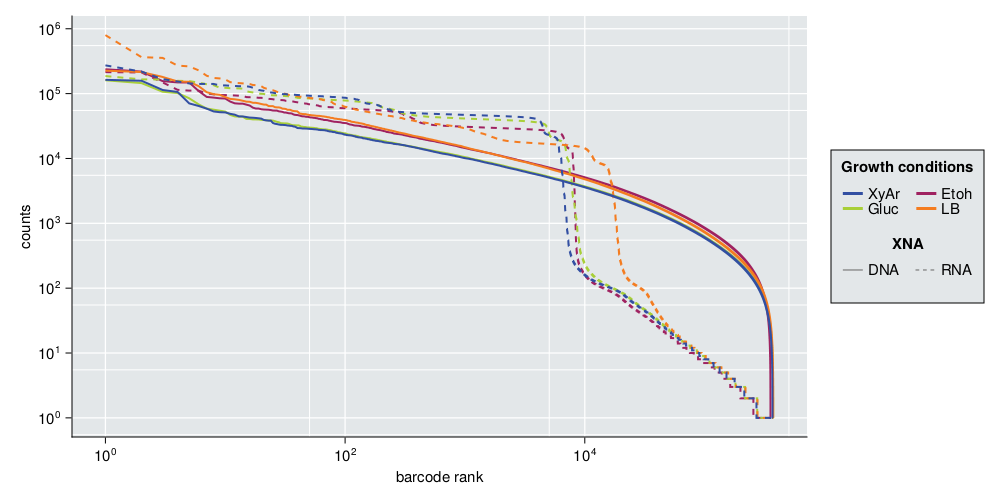

In [12]:
fig = Figure(resolution=(1000, 500))
ax = Axis(
    fig[1, 1],
    xlabel="barcode rank",
    ylabel="counts",
    yscale=log10,
    xscale=log10
    )

color_dict = Dict(
    "LB"=>wgregseq.plotting_style.my_color_dict["orange1"],
    "Etoh"=>wgregseq.plotting_style.my_color_dict["purple1"],
    "Gluc"=>wgregseq.plotting_style.my_color_dict["green1"],
    "XyAr"=>wgregseq.plotting_style.my_color_dict["blue1"]
)

style_dict = Dict(
    "gDNA"=>:solid,
    "cDNA"=>:dash
)

for file in [
        "Etoh_identified.txt",
        "Gluc_identified.txt",
        "LB_identified.txt",
        "XyAr_identified.txt"
        ]
        

    df = CSV.read(
        "../../../data/extracted_barcodes/20221114_barcode/"*file, 
        DataFrame, 
        ignorerepeated=true, 
        delim=" ", 
        )
    gc = split(file, '_')[1]
    lines!(
        ax, 
        sort(df[df.gDNA_count .> 0, :gDNA_count], rev=true),
        color=color_dict[gc],
        linestyle=style_dict["gDNA"],
        linewidth=2
    )
    lines!(
        ax, 
        sort(df[df.cDNA_count .> 0, :cDNA_count], rev=true),
        color=color_dict[gc],
        linestyle=style_dict["cDNA"],
        linewidth=2
    )
end
ax.yticklabelsize = 15
ax.xticklabelsize = 15
ax.xlabelsize = 15
ax.ylabelsize = 15
growth_conditions = keys(color_dict) |> collect
growth_conditions_lines = [LineElement(color = color_dict[gc], linewidth=3) for gc in growth_conditions]

group_color = [
    LineElement(color = :gray, linestyle=:solid),
    LineElement(color = :gray, linestyle=:dash),
    LineElement(color = :gray, linestyle=:solid, linewidth=0),
    LineElement(color = :gray, linestyle=:solid, linewidth=0)
]



legends = Legend(fig,
    [growth_conditions_lines, group_color],
    [growth_conditions, ["DNA", "RNA", " ", " "]],
    ["Growth conditions", "XNA"],
    nbanks=2,
    titlesize=15,
    labelsize=15
    
)
fig[1, 2] = legends
#axislegend(ax)
fig

## Variants per promoter identified

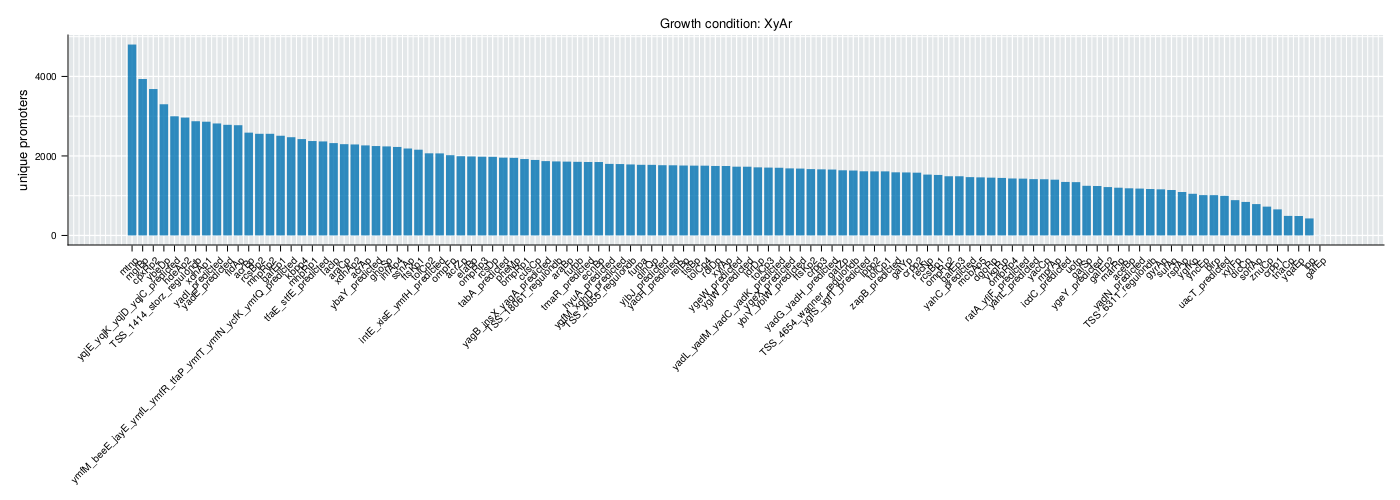

In [44]:
gc = "XyAr"
df = CSV.read(
        "../../../data/extracted_barcodes/20221114_barcode/$(gc)_identified.txt", 
        DataFrame, 
        ignorerepeated=true, 
        delim=" ", 
        )

num_unique(x) = length(unique(x))

found_promoters_df = sort(combine(groupby(df, :name), :promoter => num_unique), :promoter_num_unique, rev=true)

fig = Figure(resolution=(1400, 500))
ax = Axis(fig[1, 1], xticks = (1:nrow(found_promoters_df), found_promoters_df.name), xticklabelrotation=pi/4)
barplot!(ax, found_promoters_df.promoter_num_unique)
ax.ylabel = "unique promoters"
ax.title = "Growth condition: $gc"
fig

## How many barcodes per promoter?

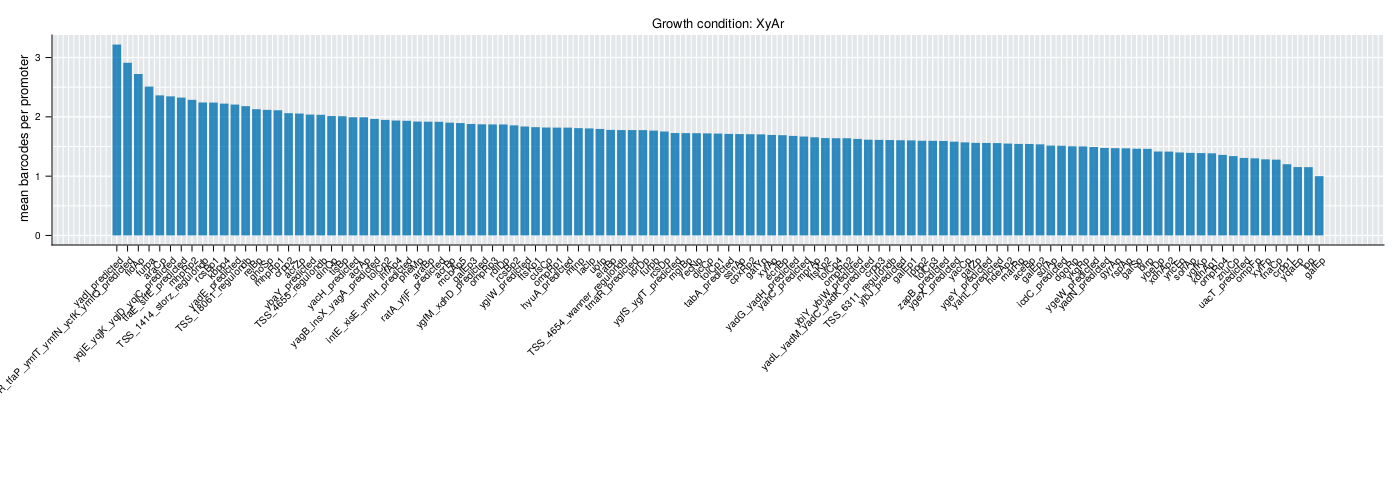

In [45]:
gc = "XyAr"
df = CSV.read(
        "../../../data/extracted_barcodes/20221114_barcode/$(gc)_identified.txt", 
        DataFrame, 
        ignorerepeated=true, 
        delim=" ", 
        )

num_unique(x) = length(unique(x))

df = combine(groupby(df, [:name, :promoter]), :barcode => num_unique)
df = sort(combine(groupby(df, [:name]), :barcode_num_unique => mean), :barcode_num_unique_mean, rev=true)

fig = Figure(resolution=(1400, 500))
ax = Axis(fig[1, 1], xticks = (1:nrow(df), df.name), xticklabelrotation=pi/4)
barplot!(ax, df.barcode_num_unique_mean)
ax.ylabel = " mean barcodes per promoter"
ax.title = "Growth condition: $gc"
fig

## Counts per barcode 

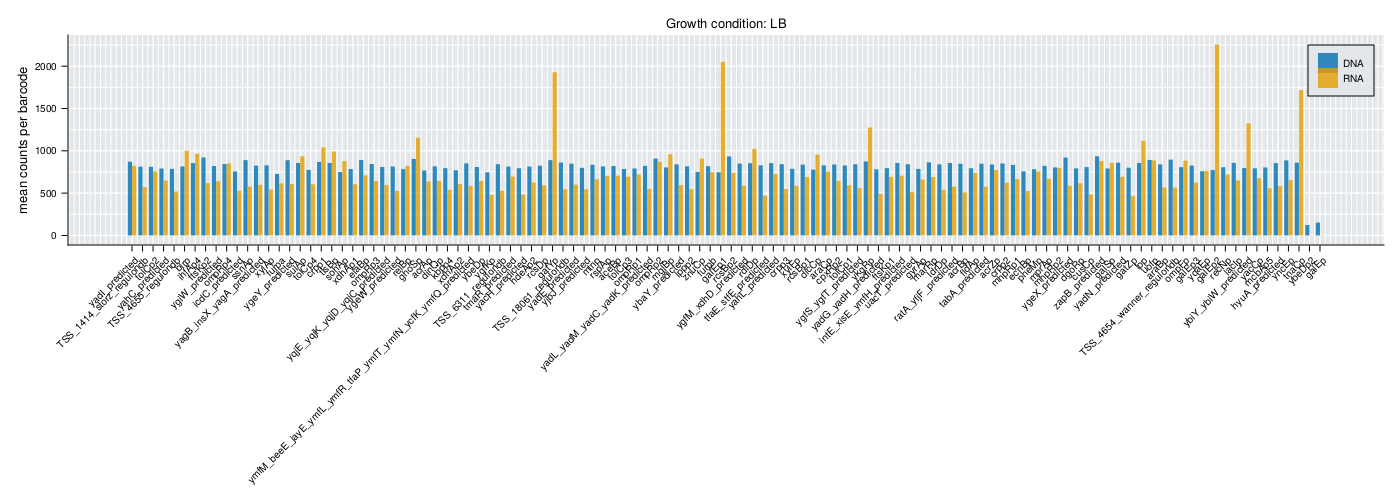

In [81]:
gc = "LB"
df = CSV.read(
        "../../../data/extracted_barcodes/20221114_barcode/$(gc)_identified.txt", 
        DataFrame, 
        ignorerepeated=true, 
        delim=" ", 
        )

num_unique(x) = length(unique(x))

df = combine(groupby(df, :name), [:gDNA_count, :cDNA_count] =>
               ((p, s) -> (mean_gDNA=mean(p), mean_cDNA=mean(s), std_gDNA=std(p), std_cDNA=std(s))) =>
               AsTable)

fig = Figure(resolution=(1400, 500))
ax = Axis(fig[1, 1], xticks = (1:nrow(df), df.name), xticklabelrotation=pi/4)
barplot!(ax, collect(1:nrow(df)) .- 0.2, df.mean_gDNA, width=0.5, label="DNA")
barplot!(ax, collect(1:nrow(df)) .+ 0.2, df.mean_cDNA, width=0.5, label="RNA")
axislegend(ax)
ax.ylabel = "mean counts per barcode"
ax.title = "Growth condition: $gc"
fig

## gDNA counts across growth conditions

In [150]:
gcs = ["LB", "Etoh", "Gluc", "XyAr"]

df_list = [
    df = CSV.read(
    "../../../data/extracted_barcodes/20221114_barcode/$(i)_identified.txt", 
    DataFrame, 
    ignorerepeated=true, 
    delim=" ", 
    )
    for i in gcs]

fig_list=[]

highlight = "rspAp"

for j in 1:length(gcs)
    for i in j+1:length(gcs)
        fig = Figure(resolution=(1200, 300))
        ax_DNA = Axis(fig[1, 1], yscale=log10, xscale=log10)
        ax_RNA = Axis(fig[1, 2], yscale=log10, xscale=log10)
        ax_rel = Axis(fig[1, 3], yscale=log10, xscale=log10)

        ax_DNA.xlabel = gcs[j]
        ax_DNA.ylabel = gcs[i]
        ax_DNA.title = "gDNA"
        
        ax_RNA.xlabel = gcs[j]
        ax_RNA.ylabel = gcs[i]
        ax_RNA.title = "cDNA"
        
        ax_rel.xlabel = gcs[j]
        ax_rel.ylabel = gcs[i]
        ax_rel.title = "relative counts"

        _df = innerjoin(df_list[j], df_list[i], on=:barcode, makeunique=true)
        f1 = _df[(_df.gDNA_count .> 0) .& (_df.gDNA_count_1 .> 0), :]
        f2 = _df[(_df.cDNA_count .> 0) .& (_df.cDNA_count_1 .> 0), :]
        f3 = _df[(_df.cDNA_count .> 0) .& (_df.cDNA_count_1 .> 0) .& (_df.gDNA_count .> 0) .& (_df.gDNA_count_1 .> 0), :]
        
        scatter!(ax_DNA, f1.gDNA_count, f1.gDNA_count_1, markersize=2)
        scatter!(ax_RNA, f2.cDNA_count, f2.cDNA_count_1, markersize=2)
        scatter!(ax_rel, f3.cDNA_count ./ f3.gDNA_count, f3.cDNA_count_1 ./ f3.gDNA_count_1, markersize=2)
        
        f1 = _df[(_df.gDNA_count .> 0) .& (_df.gDNA_count_1 .> 0) .& (_df.name .== highlight), :]
        f2 = _df[(_df.cDNA_count .> 0) .& (_df.cDNA_count_1 .> 0) .& (_df.name .== highlight), :]
        f3 = _df[(_df.cDNA_count .> 0) .& (_df.cDNA_count_1 .> 0) .& (_df.gDNA_count .> 0) .& (_df.gDNA_count_1 .> 0) .& (_df.name .== highlight), :]
        
        scatter!(ax_DNA, f1.gDNA_count, f1.gDNA_count_1, markersize=2)
        scatter!(ax_RNA, f2.cDNA_count, f2.cDNA_count_1, markersize=2)
        scatter!(ax_rel, f3.cDNA_count ./ f3.gDNA_count, f3.cDNA_count_1 ./ f3.gDNA_count_1, markersize=2)
        
        #save("figures/$(gcs[j])_$(gcs[i])_counts_compare.pdf", fig)
        push!(fig_list, fig)
    end
end

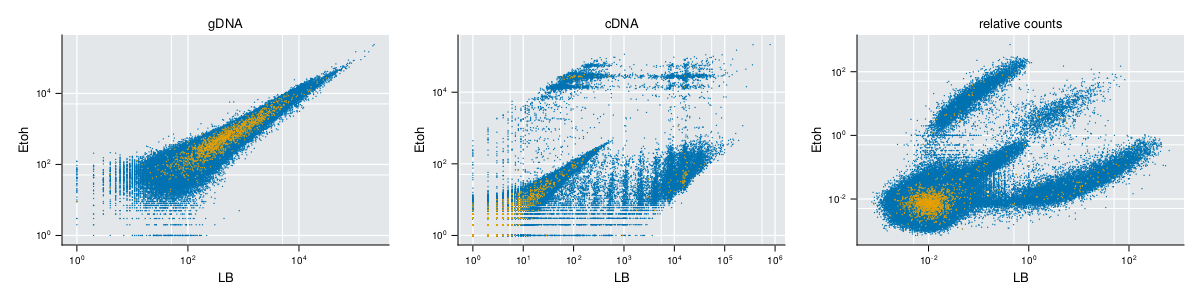

In [151]:
fig_list[1]

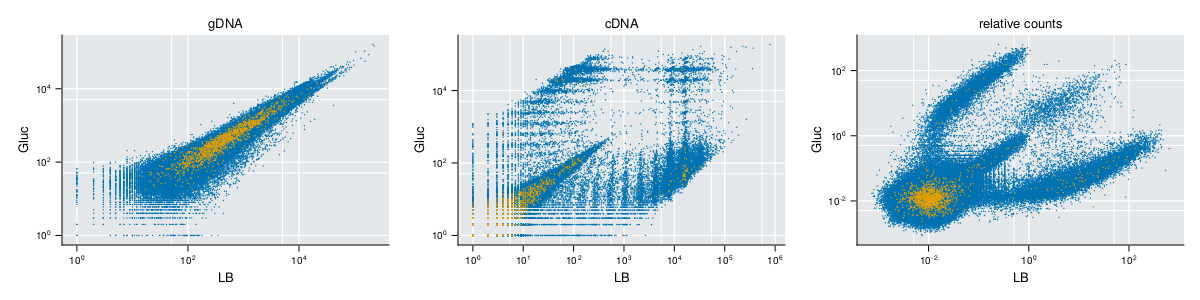

In [152]:
fig_list[2]

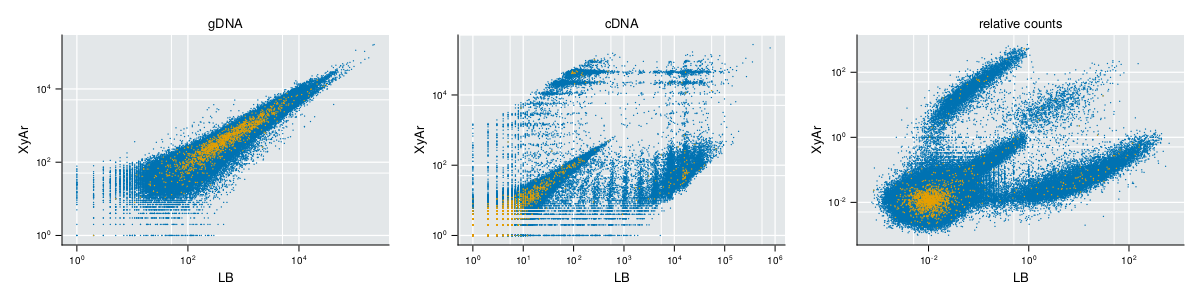

In [153]:
fig_list[3]

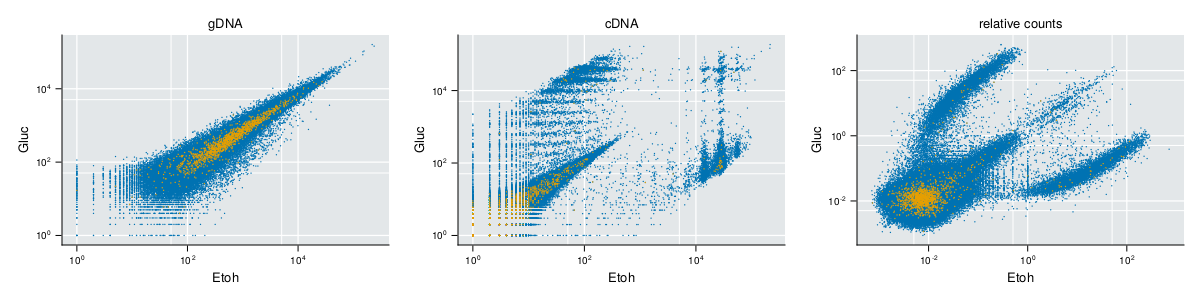

In [154]:
fig_list[4]

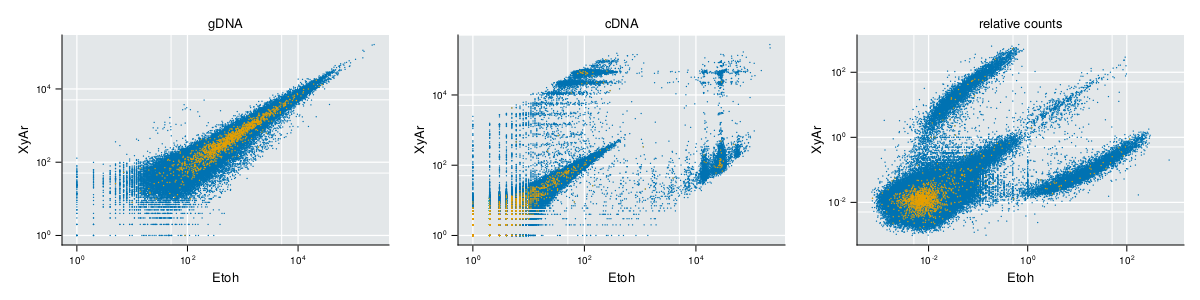

In [155]:
fig_list[5]

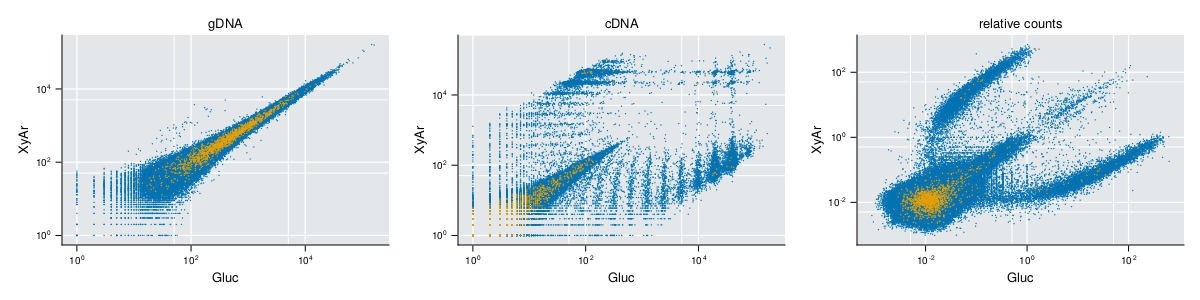

In [156]:
fig_list[6]

## Information Footprints using mpathic software

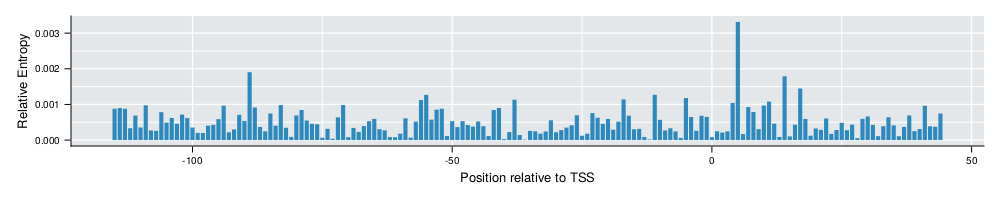

In [174]:
df = CSV.read("rspA_mcmc_mpathic.csv", DataFrame, select=[3, 4, 5, 6])

norm = sum(exp.(Matrix(df)), dims=2)
prob_mat = exp.(Matrix(df)) ./ norm
rel_entropy = [sum([prob_mat[j, i] * log2(prob_mat[j, i] / 0.25) for i in 1:4]) for j in 1:160]

fig = Figure(resolution=(1000, 200))
ax = Axis(fig[1, 1])
barplot!(ax, -115:44, rel_entropy)
ax.ylabel = "Relative Entropy"
ax.xlabel = "Position relative to TSS"

fig

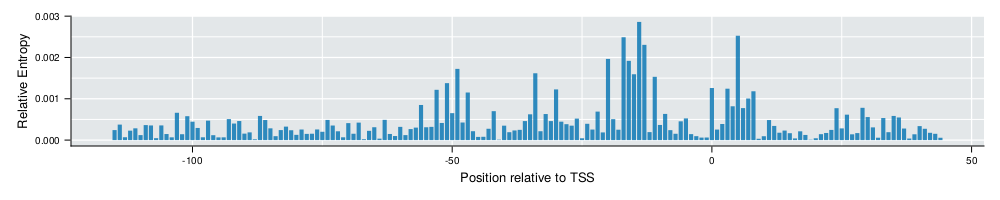

In [181]:
df = CSV.read("rspA_mcmc_mpathic_regseq_og.csv", DataFrame, select=[3, 4, 5, 6])

norm = sum(exp.(Matrix(df)), dims=2)
prob_mat = exp.(Matrix(df)) ./ norm
rel_entropy = [sum([prob_mat[j, i] * log2(prob_mat[j, i] / 0.25) for i in 1:4]) for j in 1:160]

fig = Figure(resolution=(1000, 200))
ax = Axis(fig[1, 1])
barplot!(ax, -115:44, rel_entropy)
ax.ylabel = "Relative Entropy"
ax.xlabel = "Position relative to TSS"


save("figures/rspA_eLife_footprint.pdf", fig)
fig

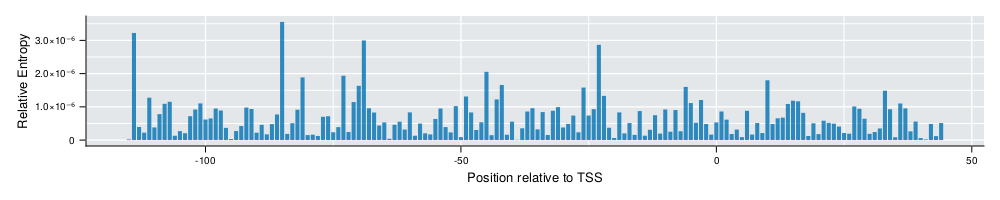

In [180]:
df = CSV.read("rspA_mcmc_mpathic_regseq_data2.csv", DataFrame, select=[3, 4, 5, 6])

norm = sum(exp.(Matrix(df)), dims=2)
prob_mat = exp.(Matrix(df)) ./ norm
rel_entropy = [sum([prob_mat[j, i] * log2(prob_mat[j, i] / 0.25) for i in 1:4]) for j in 1:160]

fig = Figure(resolution=(1000, 200))
ax = Axis(fig[1, 1])
barplot!(ax, -115:44, rel_entropy)
ax.ylabel = "Relative Entropy"
ax.xlabel = "Position relative to TSS"
save("figures/rspA_reprocessed_footprint.pdf", fig)
fig

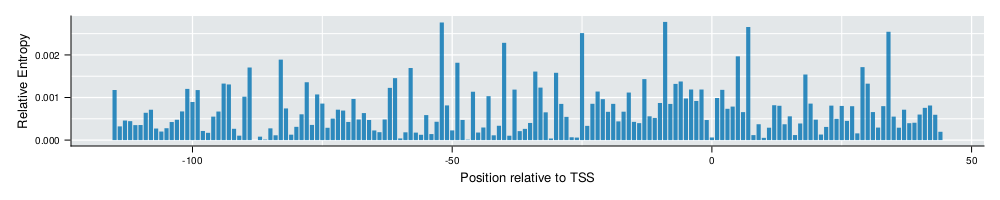

In [182]:
df = CSV.read("araC_mcmc_mpathic.csv", DataFrame, select=[3, 4, 5, 6])

norm = sum(exp.(Matrix(df)), dims=2)
prob_mat = exp.(Matrix(df)) ./ norm
rel_entropy = [sum([prob_mat[j, i] * log2(prob_mat[j, i] / 0.25) for i in 1:4]) for j in 1:160]

fig = Figure(resolution=(1000, 200))
ax = Axis(fig[1, 1])
barplot!(ax, -115:44, rel_entropy)
ax.ylabel = "Relative Entropy"
ax.xlabel = "Position relative to TSS"

save("figures/rspA_footprint.pdf", fig)

fig